### Vighnesh Mane (210021607) - PG

In [ ]:
# Google Colab Setup (reference: Lab 07)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# recall the path in Google Drive (reference: Lab 07)
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', '.DS_Store', 'Video', 'Code', 'Models', 'test_functions.ipynb']


In [ ]:
GOOGLE_DRIVE_PATH

'drive/My Drive/CW_Folder_PG'

In [ ]:
# update opencv (reference: Lab 07)
!pip install opencv-python==4.5.5.64

     |████████████████████████████████| 60.5 MB 95.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
# check correct opencv version (reference: Lab 07)
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy
Required-by: imgaug, dopamine-rl, albumentations


In [ ]:
# copy and unzip dataset directly on the Colab server (reference: Lab 07)
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

In [ ]:
# import libraries
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os
%matplotlib inline

In [ ]:
# import data from the respective directories (reference : Lab 07)
# Here we have not considered labels_list = None
def loading_im_lab_data(path):
  # getting image files from the directories
  folder_images = [folder for folder in sorted(os.listdir(path)) if folder.endswith('.jpg')]
  images = [cv2.imread(os.path.join(path, folder)) for folder in folder_images]
  # getting label files from the directories
  folder_labels = open("labels/list_label_" + path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in folder_labels]
  return images, labels
X_train, y_train = loading_im_lab_data("train")
X_test, y_test = loading_im_lab_data("test")

In [ ]:
# (reference: https://www.w3schools.com/python/ref_func_len.asp#:~:text=The%20len()%20function%20returns,of%20characters%20in%20the%20string.)
# checking the length of the training data and testing data
print(len(y_train))
print(len(y_test))

12271
3068


In [ ]:
# (reference : Lab 07)
print(Counter(y_train))
print(Counter(y_test))

Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})
Counter({'4': 1185, '7': 680, '5': 478, '1': 329, '6': 162, '3': 160, '2': 74})


### SVM_SIFT



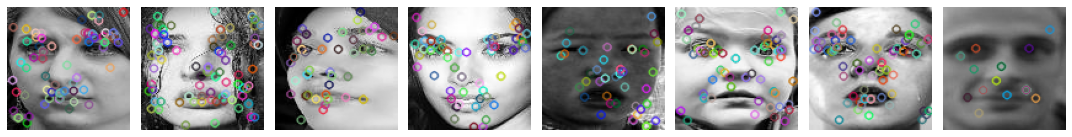

In [ ]:
# (reference: Lab 07)
# Initiate SIFT detector
sift_detect = cv2.SIFT_create()


fig, ax = plt.subplots(1, 8, figsize=(15, 8), sharey=True)
# Create empty lists for feature descriptors and labels.
descriptors_list = []
y_train_list = []

# For loop extracts a collection of feature descriptors from each image in the training batch by locating interest points
for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    keypoints, descriptors = sift_detect.detectAndCompute(img, None)

    # Show results for first 8 images
    if i<8:
        SIFT_img = cv2.drawKeypoints(img, keypoints, img)
        ax[i].imshow(SIFT_img)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if descriptors is not None:
        descriptors_list.append(descriptors)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
descriptors_array = np.vstack(descriptors_list)

In [ ]:
# (reference: Lab 07)
# Number of centroids/codewords: good rule of thumb is 10*num_classes
clusters_k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
b_size = descriptors_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=clusters_k, batch_size=b_size).fit(descriptors_array)

In [ ]:
# (reference: Lab 07)
# Convert descriptors into histograms of codewords for each image
hist_list = []
index_list = []

for descriptors in descriptors_list:
    hist = np.zeros(clusters_k)

    idx = kmeans.predict(descriptors)
    index_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(descriptors))
    hist_list.append(hist)

hist_array1 = np.vstack(hist_list)

In [ ]:
# (reference: Lab 07)
# create base svm model
# Create a classifier: a support vector classifier with kernel rbf
class_svc_sift = svm.SVC(kernel='rbf')
class_svc_sift.fit(hist_array1, y_train_list)

SVC()

In [ ]:
# (reference: Lab 07)

hist_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    keypoints, descriptors = sift_detect.detectAndCompute(img, None)

    if descriptors is not None:
        hist = np.zeros(clusters_k)

        idx = kmeans.predict(descriptors)

        for j in idx:
            hist[j] = hist[j] + (1 / len(descriptors))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list.append(hist)

    else:
        hist_list.append(None)

# Remove potential cases of images with no descriptors
index_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in index_not_empty]
y_test = [y_test[i] for i in index_not_empty]
hist_array2 = np.vstack(hist_list)

In [ ]:
# predciting the svc classifier
class_svc_sift_predict = class_svc_sift.predict(hist_array2).tolist()

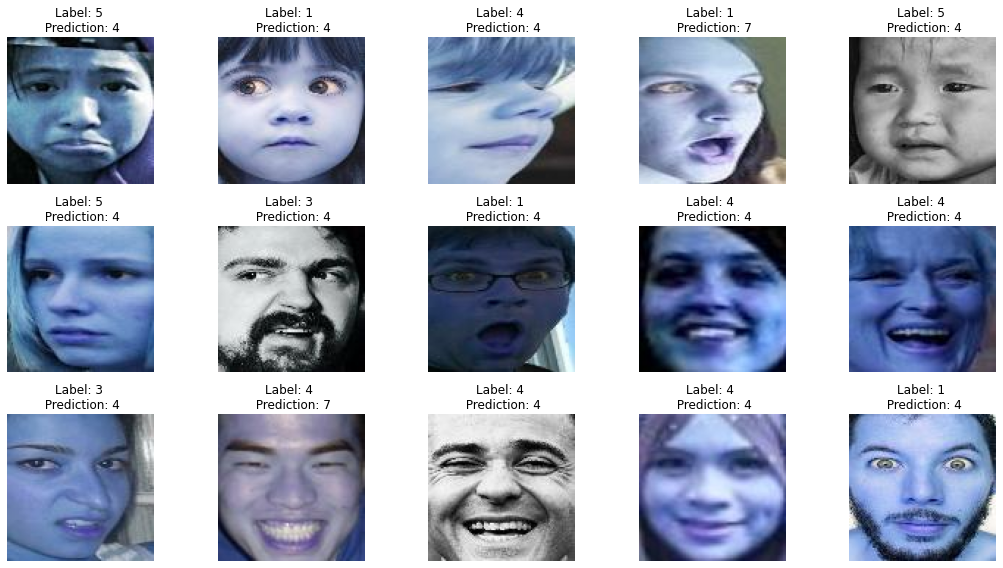

In [ ]:
# (reference: Lab 07)
# comparing labels and predicted classes on few images
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(15):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {class_svc_sift_predict[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_svc_sift}:
      {metrics.classification_report(y_test, class_svc_sift_predict)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.40      0.07      0.12       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.43      0.85      0.57      1183
           5       0.30      0.06      0.11       478
           6       0.00      0.00      0.00       161
           7       0.38      0.33      0.35       680

    accuracy                           0.42      3065
   macro avg       0.22      0.19      0.16      3065
weighted avg       0.34      0.42      0.33      3065




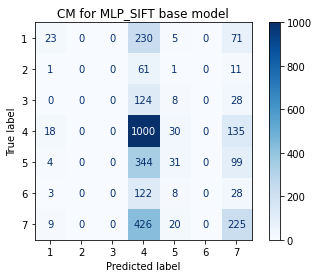

In [ ]:
# (reference : Lab 07)
# confusion matrix for base svm_sift model
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_svc_sift_predict,cmap=plt.cm.Blues)
plt.title('CM for MLP_SIFT base model')
plt.show()

In [ ]:
# (reference : https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/)
# SVM_SIFT with best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
grid_hyperpara = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001]}
grid_search = GridSearchCV(SVC(), grid_hyperpara,refit = True, verbose=3)
grid_search.fit(hist_array1, y_train_list)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=   6.8s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=   6.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=   6.6s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=   6.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.389 total time=   6.6s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.389 total time=   6.8s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.389 total time=   7.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.389 total time=   6.7s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.389 total time=   6.9s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.389 total time=   6.9s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.389 total time=  11.5s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf

In [ ]:
# (reference: Lab 07)
# create svm model with best hyperparameters obtained from grid search
# Create a classifier: a support vector classifier with best hyperparameters
class_svc_sift_best_para = svm.SVC(kernel='rbf',C = 100,gamma = 1)
class_svc_sift_best_para.fit(hist_array1, y_train_list)

SVC(C=100, gamma=1)

In [ ]:
# predciting the best svc classifier
class_svc_sift_best_predict = class_svc_sift_best_para.predict(hist_array2).tolist()

In [ ]:
#(reference: Lab 07)
import warnings
warnings.filterwarnings("ignore")
#quantitative evaluation of the model's performance
print(f"""Classification report for classifier {class_svc_sift_best_para}:
      {metrics.classification_report(y_test, class_svc_sift_best_predict)}\n""")

Classification report for classifier SVC(C=100, gamma=1):
                    precision    recall  f1-score   support

           1       0.50      0.04      0.07       329
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00       160
           4       0.42      0.92      0.57      1183
           5       0.30      0.01      0.01       478
           6       0.00      0.00      0.00       161
           7       0.38      0.24      0.29       680

    accuracy                           0.41      3065
   macro avg       0.23      0.17      0.14      3065
weighted avg       0.35      0.41      0.30      3065




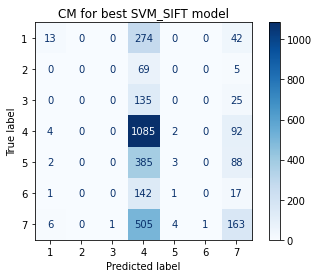

In [ ]:
# (reference : Lab 07)
# confusion matrix for svm_sift model with best hyperparameters
metrics.ConfusionMatrixDisplay.from_predictions(y_test, class_svc_sift_best_predict,cmap=plt.cm.Blues)
plt.title('CM for best SVM_SIFT model')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# (reference : Lab 07)
from joblib import dump, load
dump(class_svc_sift_best_para, 'svm_sift.joblib')


['svm_sift.joblib']

In [ ]:
class_svc_sift_best_para = load('svm_sift.joblib')